In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [5]:
#reset function
def init_paths():
    agent_=defaultdict(dict)
    for i in range(N_agents):
        agent_[i]['theta']= thetas[i]
        agent_[i]['action'] = np.zeros(N)
        agent_[i]['state'] = np.zeros(N)
        agent_[i]['reward'] = np.zeros(N)
    return agent_

def reward(r,n):
    beta=0.99
    return (beta**n)*(r + np.random.gumbel(0,1,r.shape))
    
def step(a,n):
    x = a.count(a[0]) == len(a) #checks if actions are similar
    for i,j in enumerate(a):
        if x:
            agent_[i]['reward'][n+1]=reward(R[1][j],n)
            agent_[i]['state'][n+1] =1
        else:
            agent_[i]['reward'][n+1] = reward(R[0][j],n)
            agent_[i]['state'][n+1] = 0
    return

#softmax policy
def policy(state,theta):
    x = state*theta
    exp = np.exp(x)
    return exp/np.sum(exp)

#leastsquare
def linreg(x,y):
    # assemble matrix A
    A = np.vstack([x, np.ones(x.size)]).T
    if x.size == 1:
        y=np.array([y])
        
    y = y[:, np.newaxis]
    pinv = np.linalg.pinv(A)
    res = pinv.dot(y)[0]
    #res = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)[0]
    return res

def critic(data,agent,state):
    n = agent
    s = state
    rewards_arr = np.array([data[i][n]['reward'] for i in range(M)]).reshape(M,N)
    actions_arr = np.array([data[i][n]['action'] for i in range(M)]).reshape(M,N)
    state_arr = np.array([data[i][n]['state'] for i in range(M)]).reshape(M,N)
    ss = np.sum(state_arr,axis=0)
    t = 200 #snapshot
    
    state_t = state_arr[:,t]

    temp1 = np.where(state_t==s)[0]
    action_t= actions_arr[:,t:][temp1] #select action space of s=0/1
    reward_s= rewards_arr[:,t:][temp1] #select reward space of s=0/1

    q_s=[]
    rew_s =[]
    v_sa = []
    pi_s = policy(R[s],thetas[n][:,s])
    for i in range(N_actions):
        temp2 = np.where(action_t[:,0]==i)[0]
        rewards_t = reward_s[temp2]
        if len(temp2)==0:
            q_s.append(0)
            rew_s.append(0)
            v_sa.append(0)
        else:
            q_s.append(np.sum(rewards_t,axis=1))
            rew_s.append(rewards_t[:,0])
            v_sa.append(np.sum(q_s[i]*pi_s[i]))
            
    if len(temp1)==0:
        v_s = 0
    else:
        v_s = np.sum(v_sa)/len(temp1)
    
    A_s = [(q_s[i] - v_s) for i in range(N_actions)]
    
    return temp1,A_s,rew_s,pi_s,np.sum(rewards_arr)/M

def policygrad(d,A_s,rew_s,pi_s,s):
    temp = np.sum(pi_s*R[s])
    grad=[]
    for i in range(N_actions):
        res = rew_s[i] - temp #phi(s,a) - sum_a (phi(s,a)*pi(s,a))
        omega = linreg(res,A_s[i])
        grad.append(np.sum(omega*res)/res.size)

    return np.array(grad)

In [9]:
N_actions = 5
A = 4
N_agents = 4
M= 10
N=1000
N_state = 2
act = np.arange(0,N_actions)
agents = np.arange(1,N_agents+1)
alpha = 0.001


#Observations
r_0 = (act -(A/2))**2
r_1 = (act -(A/2))**2 + N_agents
R = np.vstack((r_0,r_1))

# Init Parameter
#row0 for state0
#row1 for state1
np.random.seed(1)
thetas = {i: np.random.rand(N_actions, N_state) for i in range(N_agents)}

b = 0.99**np.arange(N)
d = np.array([b for i in range(M)]).reshape(M,N)

score_stat=[]

for iterations in range(500):
    old_theta = thetas
    data = []

    for m in range(M):
        agent_ = init_paths()
    
        for n in range(N-1):
            a = []
            for i in range(N_agents):
                s = agent_[i]['state'][n] #current state 0/1
                if s:
                    #p = policy(agent_[i]['reward'][n],agent_[i]['theta'][:,1])
                    p = policy(R[1],agent_[i]['theta'][:,1])
                else:
                    #p = policy(agent_[i]['reward'][n],agent_[i]['theta'][:,0])
                    p = policy(R[0],agent_[i]['theta'][:,0])
                action = np.random.choice(N_actions,p=p)
                a.append(action)
                agent_[i]['action'][n+1]=action
            step(a,n)

        data.append(agent_)
    
    avg_r = []
    for b in range(N_agents):
        for s in range(N_state):
            temp,A_hat,rew,pi_,score = critic(data,b,s) #critic(data,agent,state)
            grad = policygrad(d,A_hat,rew,pi_,s)
            if len(temp)==0:
                d_s=0
            else:
                d_s = np.sum(d[:,200:][temp])/len(temp)
            thetas[b][:,s] = thetas[b][:,s]+(alpha*(d_s*grad))
        avg_r.append(score)
        
    if iterations % 20 ==0:
        print("iteration- ",iterations,";  sample actions- ",a,";  average reward- ",np.mean(avg_r))
        #print("thetas:",thetas[0],thetas[1],thetas[2],thetas[3])
    score_stat.append(avg_r)


iteration-  0 ;  sample actions-  [0, 0, 0, 1] ;  average reward-  365.72747191784305
iteration-  20 ;  sample actions-  [4, 4, 3, 1] ;  average reward-  284.28291518225166
iteration-  40 ;  sample actions-  [4, 2, 3, 3] ;  average reward-  234.96090831455984
iteration-  60 ;  sample actions-  [4, 2, 3, 3] ;  average reward-  184.93508708383985
iteration-  80 ;  sample actions-  [4, 2, 2, 1] ;  average reward-  182.82039030067395
iteration-  100 ;  sample actions-  [4, 2, 3, 2] ;  average reward-  180.17822143285065
iteration-  120 ;  sample actions-  [0, 0, 0, 0] ;  average reward-  841.6907104795662
iteration-  140 ;  sample actions-  [0, 0, 0, 0] ;  average reward-  840.6466390871744
iteration-  160 ;  sample actions-  [0, 0, 0, 0] ;  average reward-  831.6524302217043
iteration-  180 ;  sample actions-  [0, 0, 0, 0] ;  average reward-  843.8743867952697
iteration-  200 ;  sample actions-  [0, 0, 0, 0] ;  average reward-  842.4898735539649
iteration-  220 ;  sample actions-  [0, 0, 

KeyboardInterrupt: 

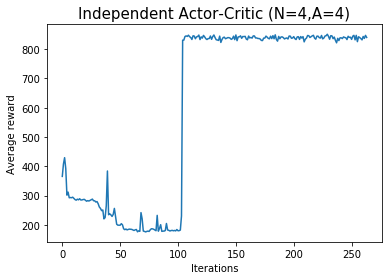

In [10]:
#graph
y = [np.mean(score_stat[i]) for i in range(len(score_stat))]
plt.plot(y)
plt.title("Independent Actor-Critic (N=4,A=4)", fontsize=15)
plt.xlabel("Iterations")
plt.ylabel("Average reward")
plt.show()